# Loading packages and the RNN files

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
def cos_sim(a,b):
    cos_sim = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

def get_cis(x):
    ci_h = np.zeros([x.shape[1],2])
    for idx in range(x.shape[1]):
        data = x[:,idx]
        ci_h[idx,:] = scipy.stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),
                                             scale=scipy.stats.sem(data))
    return ci_h

In [3]:
# loading miniecoset labels

dataset_path = './miniecoset_64px.h5'

with h5py.File(dataset_path, "r") as f:
    category_labels = f['categories'][()]
    sample_image = f['train']['data'][0,:,:,:]
    
for i in range(len(category_labels)):
    category_labels[i] = category_labels[i].decode()

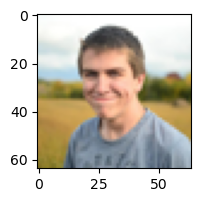

In [4]:
# sample image from miniecoset

plt.figure(figsize=(2, 2))
plt.imshow(sample_image)

In [5]:
# loading the relevant net save file

lateral_connections = 1
topdown_connections = 0
lt_interact = 'additive'
timesteps = 10
lt_position = 'all'
net_num = 1

load_epoch = -2 # this loads the final model (-1 loads the random init)

net_name = f'b64_l_{lateral_connections}_t_{topdown_connections}_ltinteract_{lt_interact}\
_T_{timesteps}_ltposition_{lt_position}_num_{net_num}'

if load_epoch == -2:
    actvs_save_name = f'saved_actvs/{net_name}/{net_name}.npz'
else:
    actvs_save_name = f'saved_actvs/{net_name}/{net_name}_epoch_{load_epoch}.npz'

print('Net_file: ',actvs_save_name)

actvs_save_name_init = f'saved_actvs/{net_name}/{net_name}_epoch_{-1}.npz'

Net_file:  saved_actvs/b64_l_1_t_0_ltinteract_additive_T_10_ltposition_all_num_1/b64_l_1_t_0_ltinteract_additive_T_10_ltposition_all_num_1.npz


In [6]:
# loading the relevant net representations and parameters

data = np.load(actvs_save_name)
outputs_all = np.exp(data['outputs_all'])
outputs_all_labels = data['labels_all']
avgpool_all = data['representations_all']
rdout_w = data['readout_weight'].T
rdout_b = data['readout_bias']

data = np.load(actvs_save_name_init)
outputs_all_init = np.exp(data['outputs_all'])
avgpool_all_init = data['representations_all']
rdout_w_init = data['readout_weight'].T
rdout_b_init = data['readout_bias']

# Analysis

### Categorisation accuracy through time

t for max accuracy:  6 ; acc =  53.344 %



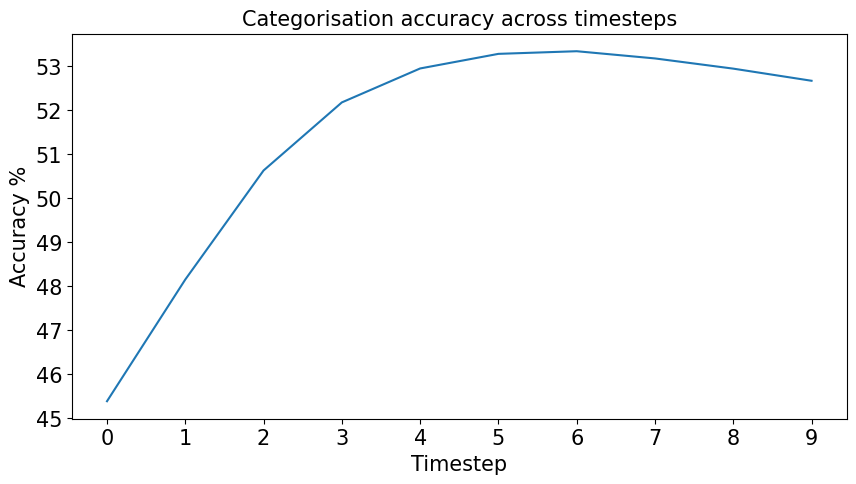

In [7]:
acc_t = np.zeros([timesteps,])
acc_t_init = np.zeros([timesteps,])
for t in range(timesteps):
    acc_t[t] = np.mean(np.argmax(outputs_all[t],axis=1)*1. == outputs_all_labels)
    acc_t_init[t] = np.mean(np.argmax(outputs_all_init[t],axis=1)*1. == outputs_all_labels)
    
plt.figure(figsize=(10,5))
plt.plot(range(timesteps),acc_t*100)
# plt.plot(range(timesteps),acc_t_init*100)
plt.yticks(fontsize=15);
plt.xticks(range(timesteps),fontsize=15);
plt.ylabel('Accuracy %',fontsize=15)
plt.xlabel('Timestep',fontsize=15)
plt.title('Categorisation accuracy across timesteps',fontsize=15);

print('t for max accuracy: ',np.argmax(acc_t),'; acc = ',np.max(acc_t)*100,'%\n')

### Dendrogram of readout vectors

In [8]:
# rdmh = (1-np.corrcoef(rdout_w.T))/2
rdmh = np.zeros([100,100])
for i in range(100):
    for j in range(100):
        rdmh[i,j] = (1-cos_sim(rdout_w[:,i],rdout_w[:,j]))/2
rdmh = (rdmh+rdmh.T)/2
for i in range(100):
    rdmh[i,i] = 0
rdm_readout = squareform(rdmh)

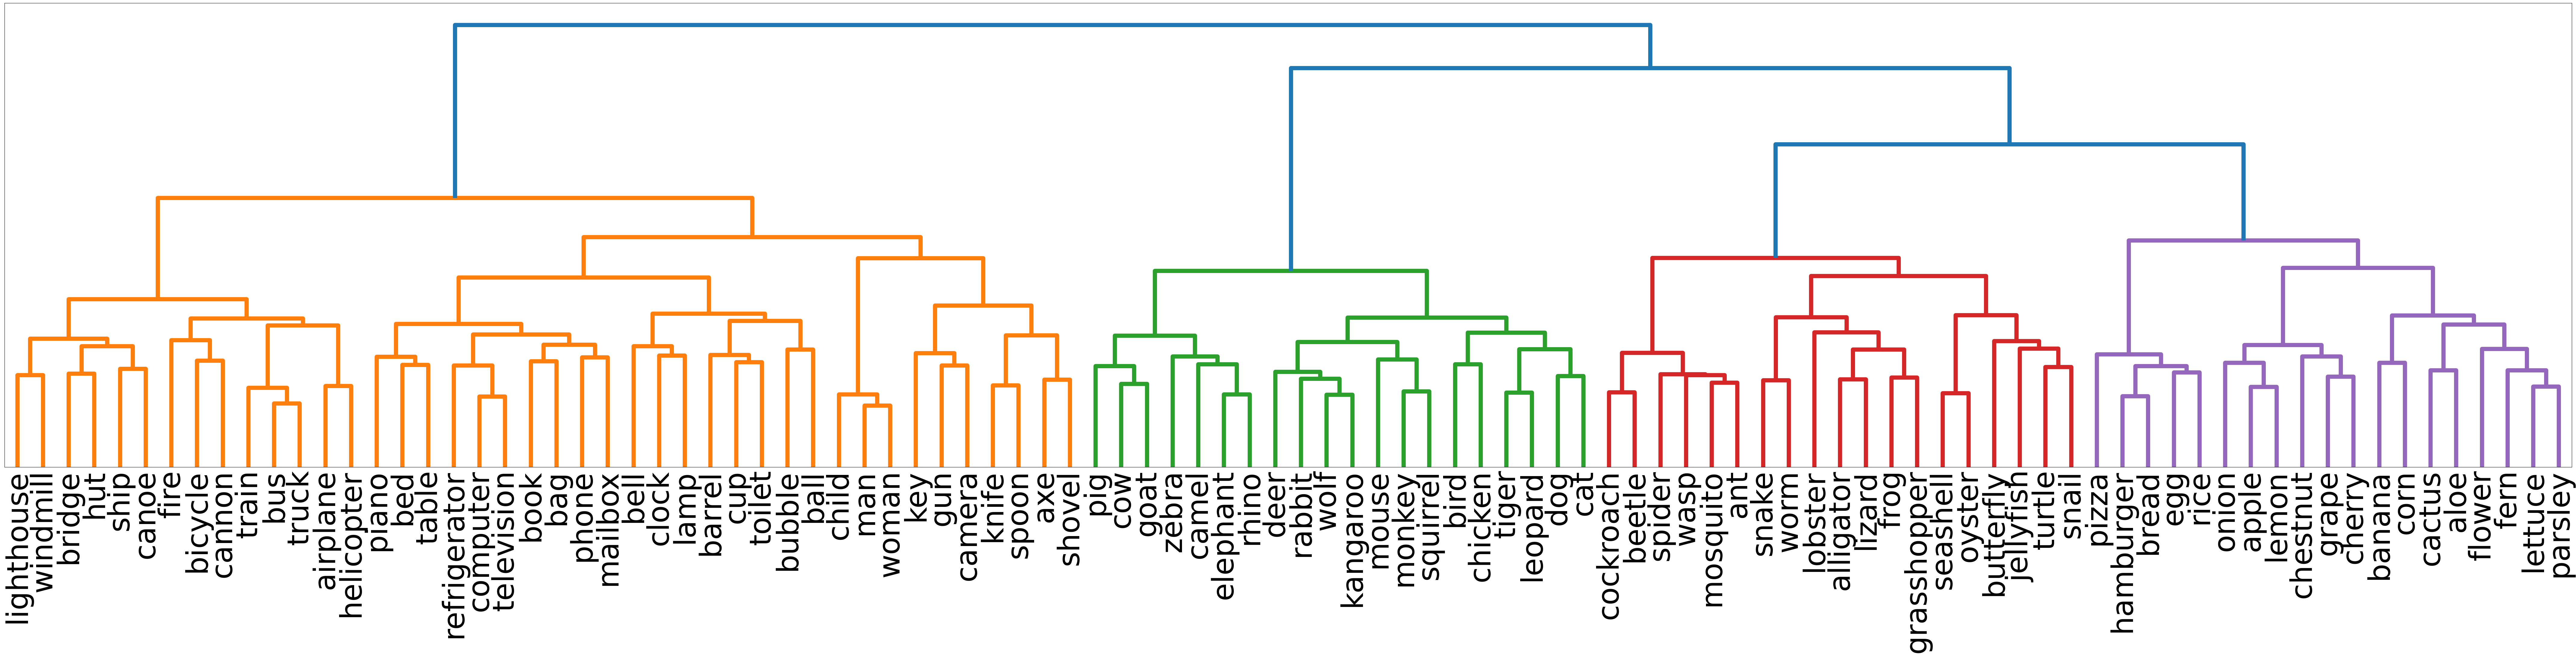

In [9]:
plt.figure(figsize=(110, 20))
linkage_data = linkage(rdm_readout, method='ward', metric='euclidean');
with plt.rc_context({'lines.linewidth': 10}):
    sort_dict_ft = dendrogram(linkage_data, labels=category_labels);
plt.tick_params(axis='x', which='major', labelsize=70)
# plt.tick_params(axis='y', which='major', labelsize=25)
plt.yticks([]);
# plt.savefig('miniecoset_blt_readout_hierarchy.png',dpi=300, bbox_inches='tight')

### Extracting the splits based on classification dynamics

In [10]:
stable_correct_ids = []
t_stable_correct = []

stable_incorrect_ids = []
t_stable_incorrect = []
label_stable_incorrect = []

unstable_correct_ids = []
t_unstable_correct = []
unstable_incorrect_ids = []

for idx in range(len(outputs_all_labels)):
    
    stability_flag = 0
    true_label = int(outputs_all_labels[idx])
    output_label_t = np.argmax(outputs_all[:,idx,:],1)
    for t in reversed(range(timesteps-1)):
        t_class_now = np.argmax(outputs_all[t,idx,:])
        t_class_next = np.argmax(outputs_all[t+1,idx,:])
        if t_class_now == t_class_next:
            stability_flag = 1
        else:
            if stability_flag == 1:
                t_first_stable = t+1
                stable_class = t_class_next
                if np.min(np.where(np.argmax(outputs_all[:,idx,:],1) == stable_class)[0]) == t_first_stable: #stable
                    if stable_class == true_label: #stable-correct
                        stable_correct_ids.append(idx)
                        t_stable_correct.append(t_first_stable)
                    else: #stable-incorrect
                        stable_incorrect_ids.append(idx)
                        t_stable_incorrect.append(t_first_stable)
                        label_stable_incorrect.append(stable_class)
                else: #unstable
                    if true_label in np.argmax(outputs_all[:,idx,:],1): #unstable_correct
                        unstable_correct_ids.append(idx)
                        t_unstable_correct.append(np.min(np.where(np.argmax(outputs_all[:,idx,:],1) == true_label)[0]))
                    else: #unstable_incorrect
                        unstable_incorrect_ids.append(idx)
                stability_flag = 0
                break
            else: #unstable - can only be hit at timestep-1
                if true_label in np.argmax(outputs_all[:,idx,:],1): #unstable_correct
                    unstable_correct_ids.append(idx)
                    t_unstable_correct.append(np.min(np.where(np.argmax(outputs_all[:,idx,:],1) == true_label)[0]))
                else: #unstable_incorrect
                    unstable_incorrect_ids.append(idx)
                stability_flag = 0
                break
    if stability_flag == 1: #stable - can only be hit if stable throughout
        stable_class = t_class_next
        if stable_class == true_label: #stable-correct
            stable_correct_ids.append(idx)
            t_stable_correct.append(0)
        else: #stable-incorrect
            stable_incorrect_ids.append(idx)
            t_stable_incorrect.append(0)
            label_stable_incorrect.append(stable_class)

print(f'Total samples #: {len(outputs_all_labels)}, 100.0%')
print(f'Stable_correct #: {len(stable_correct_ids)}, {len(stable_correct_ids)/len(outputs_all_labels)*100.:.1f}%')
print(f'Stable_incorrect #: {len(stable_incorrect_ids)}, {len(stable_incorrect_ids)/len(outputs_all_labels)*100.:.1f}%')
print(f'Unstable_correct #: {len(unstable_correct_ids)}, {len(unstable_correct_ids)/len(outputs_all_labels)*100.:.1f}%')
print(f'Unstable_incorrect #: {len(unstable_incorrect_ids)}, {len(unstable_incorrect_ids)/len(outputs_all_labels)*100.:.1f}%')

stable_correct_ids = np.array(stable_correct_ids)
t_stable_correct = np.array(t_stable_correct)
stable_incorrect_ids = np.array(stable_incorrect_ids)
t_stable_incorrect = np.array(t_stable_incorrect)
label_stable_incorrect = np.array(label_stable_incorrect)
unstable_correct_ids = np.array(unstable_correct_ids)
t_unstable_correct = np.array(t_unstable_correct)
unstable_incorrect_ids = np.array(unstable_incorrect_ids)
        

Total samples #: 25000, 100.0%
Stable_correct #: 12418, 49.7%
Stable_incorrect #: 9850, 39.4%
Unstable_correct #: 1295, 5.2%
Unstable_incorrect #: 1437, 5.7%


#samples per t (trained):  [9609, 917, 627, 411, 285, 219, 159, 103, 88, 0]


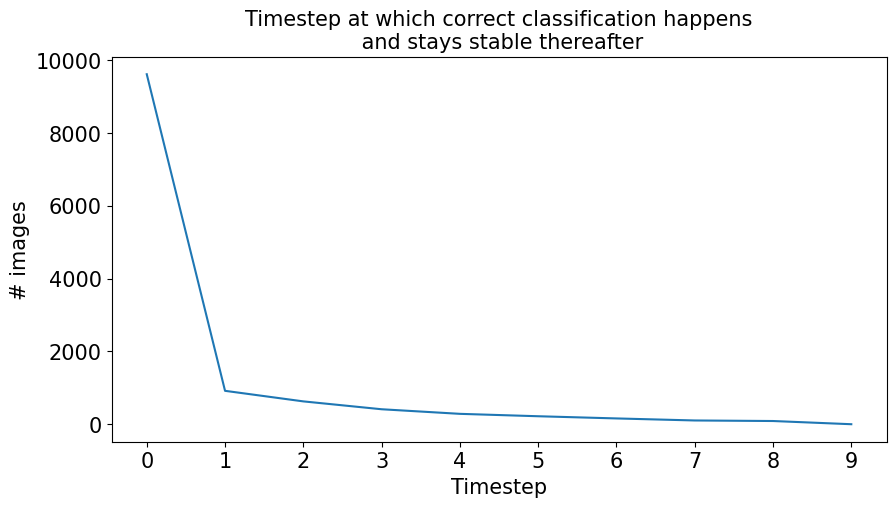

In [11]:
t_arr_trained = [np.sum(t_stable_correct==t) for t in range(timesteps)]
print('#samples per t (trained): ',t_arr_trained)

plt.figure(figsize=(10,5))
plt.plot(range(timesteps),t_arr_trained)
plt.yticks(fontsize=15);
plt.xticks(range(np.shape(outputs_all)[0]),fontsize=15);
plt.ylabel('# images',fontsize=15)
plt.xlabel('Timestep',fontsize=15)
plt.title('Timestep at which correct classification happens\n and stays stable thereafter',fontsize=15);

### Change in representation as a function of time to (correct) stable classification

It seems that all representations change to the same extent. The change decreases in time too. Why might that be? 
In any case, stable classifications are not accompanied by stagnant representations.


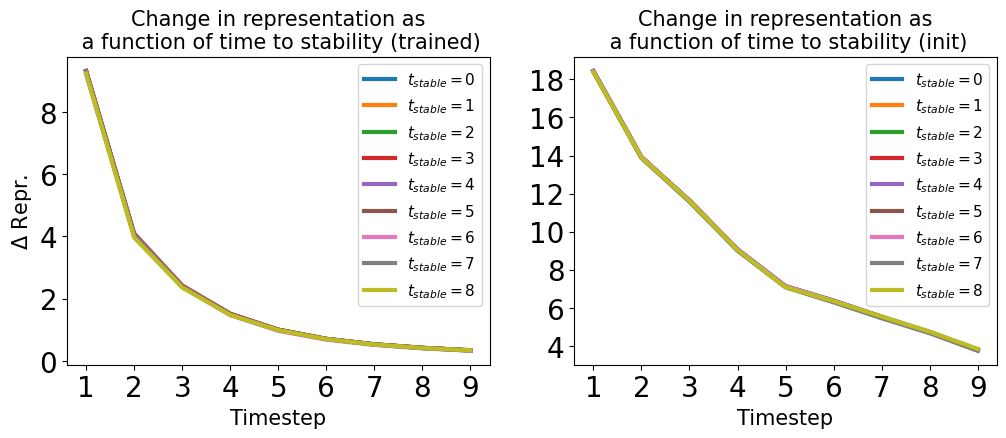

In [12]:
norm_change_in_repr = np.zeros([len(stable_correct_ids),timesteps-1])
norm_change_in_repr_init = np.zeros([len(stable_correct_ids),timesteps-1])

for n,idx in enumerate(stable_correct_ids):
    for t in range(timesteps-1):
        norm_change_in_repr[n,t] = norm(avgpool_all[t+1,idx,:]-avgpool_all[t,idx,:])
        norm_change_in_repr_init[n,t] = norm(avgpool_all_init[t+1,idx,:]-avgpool_all_init[t,idx,:])
        
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for t in range(timesteps-1):
    plt.plot(np.arange(timesteps-1)+1,np.mean(norm_change_in_repr[t_stable_correct==t,:],0), linewidth=3)
plt.legend([f'$t_{{stable}} = {t}$' for t in range(timesteps)],fontsize=11)
plt.yticks(fontsize=20);
plt.xticks(fontsize=20);
plt.ylabel(r'$\Delta$ Repr.',fontsize=15)
plt.xlabel('Timestep',fontsize=15)
plt.title('Change in representation as\n a function of time to stability (trained)',fontsize=15);
plt.subplot(1,2,2)
for t in range(timesteps-1):
    plt.plot(np.arange(timesteps-1)+1,np.mean(norm_change_in_repr_init[t_stable_correct==t,:],0),linewidth=3)
plt.legend([f'$t_{{stable}} = {t}$' for t in range(timesteps)],fontsize=11)
plt.yticks(fontsize=20);
plt.xticks(fontsize=20);
# plt.ylabel(r'$\Delta$ Repr.',fontsize=15)
plt.xlabel('Timestep',fontsize=15)
plt.title('Change in representation as\n a function of time to stability (init)',fontsize=15);

print('It seems that all representations change to the same extent. The change decreases in time too. \
Why might that be? \nIn any case, stable classifications are not accompanied by stagnant representations.')


In [13]:
timesteps_analyse = np.where(t_arr_trained < t_arr_trained[0]/100)[0][0]
# only analyse dynamics of repr that stabilize before this timestep
print('Max t_stable that will be analysed further: ',timesteps_analyse)

Max t_stable that will be analysed further:  8


## Signatures of stability

### Are the norms between stable now vs stable later representations different?

In [14]:
norm_stability = np.zeros([timesteps,2])*np.nan # stable-now, stable-later

for t in range(timesteps):
    if t > -1:
        norm_stability[t,0] = np.mean(norm(avgpool_all[t,stable_correct_ids[t_stable_correct<t+1],:],axis=1))
    if t < timesteps-1:
        norm_stability[t,1] = np.mean(norm(avgpool_all[t,stable_correct_ids[t_stable_correct>t],:],axis=1))

/opt/homebrew/anaconda3/envs/pytorch@1.12.1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/envs/pytorch@1.12.1/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The norms of representations that will move out of readout zones are lower.


array([8.47850529, 7.9147774 ])

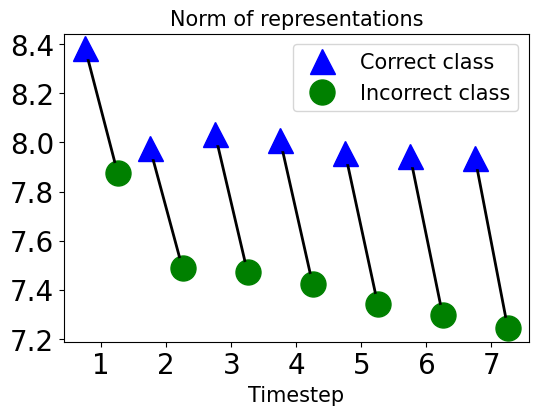

In [15]:
plt.figure(figsize=(6,4))
for t in range(1,timesteps_analyse):
    plt.plot(2*t,norm_stability[t,0],'^', color='blue',markersize=18)
    plt.plot(2*t+1,norm_stability[t,1],'o', color='green',markersize=18)
    plt.plot(range(2*(t),2*t+2),norm_stability[t,:],'k-',linewidth=2)
    plt.plot(2*t,norm_stability[t,0],'^', color='blue',markersize=15)
    plt.plot(2*t+1,norm_stability[t,1],'o', color='green',markersize=15)
plt.legend(['Correct class','Incorrect class'],fontsize=15)
plt.yticks(fontsize=20);
plt.xticks(np.arange(1,timesteps_analyse)*2+0.5,labels=range(1,timesteps_analyse),fontsize=20);
plt.xlabel('Timestep',fontsize=15)
plt.title('Norm of representations',fontsize=15);

print('The norms of representations that will move out of readout zones are lower.')

to_avg_t = np.invert(np.isnan(np.mean(norm_stability[:timesteps_analyse,:],axis=1)))
np.mean(norm_stability[np.arange(timesteps_analyse)[to_avg_t],:],axis=0)

### Are the stable now repr. closer to current readout vector?

In [16]:
cos_currclass_stability = np.zeros([timesteps,2])*np.nan # stable-now, stable-later

for t in range(timesteps):
    
    for idx in range(len(t_stable_correct)):
        if t_stable_correct[idx] < t+1:
            if np.isnan(cos_currclass_stability[t,0]):
                cos_currclass_stability[t,0] = 0.
            cos_currclass_stability[t,0] += cos_sim(avgpool_all[t,stable_correct_ids[idx],:],
                                                    rdout_w[:,np.argmax(outputs_all[t,stable_correct_ids[idx],:])])
        if t_stable_correct[idx] > t:
            if np.isnan(cos_currclass_stability[t,1]):
                cos_currclass_stability[t,1] = 0.
            cos_currclass_stability[t,1] += cos_sim(avgpool_all[t,stable_correct_ids[idx],:],
                                                    rdout_w[:,np.argmax(outputs_all[t,stable_correct_ids[idx],:])])  
            
    if not np.isnan(cos_currclass_stability[t,0]):
        cos_currclass_stability[t,0] = cos_currclass_stability[t,0]/np.sum(t_stable_correct < t+1)
    if not np.isnan(cos_currclass_stability[t,1]):
        cos_currclass_stability[t,1] = cos_currclass_stability[t,1]/np.sum(t_stable_correct > t)
        

The cosines with current readout vector of representations that will move out of readout zones are lower.


array([0.20195133, 0.1209265 ])

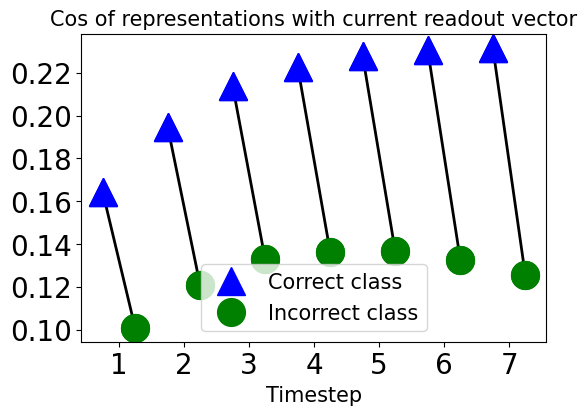

In [17]:
plt.figure(figsize=(6,4))
for t in range(1,timesteps_analyse):
    plt.plot(2*t,cos_currclass_stability[t,0],'^', color='blue',markersize=20)
    plt.plot(2*t+1,cos_currclass_stability[t,1],'o', color='green',markersize=20)
    plt.plot(range(2*(t),2*t+2),cos_currclass_stability[t,:],'k-',linewidth=2)
    plt.plot(2*t,cos_currclass_stability[t,0],'^', color='blue',markersize=20)
    plt.plot(2*t+1,cos_currclass_stability[t,1],'o', color='green',markersize=20)
plt.legend(['Correct class','Incorrect class'],fontsize=15)
plt.yticks(fontsize=20);
plt.xticks(np.arange(1,timesteps_analyse)*2+0.5,labels=range(1,timesteps_analyse),fontsize=20);
plt.xlabel('Timestep',fontsize=15)
plt.title('Cos of representations with current readout vector',fontsize=15);

print('The cosines with current readout vector of representations that will move out of readout zones are lower.')

to_avg_t = np.invert(np.isnan(np.mean(cos_currclass_stability[:timesteps_analyse,:],axis=1)))
np.mean(cos_currclass_stability[np.arange(timesteps_analyse)[to_avg_t],:],axis=0)

### Are the stable-after repr. close to their final class?

In [18]:
cos_classes_unstable = np.zeros([timesteps,2])*np.nan # final-class, other-classes-currently

for t in range(timesteps):
    
    idx_h = stable_correct_ids[t_stable_correct > t]
    if len(idx_h) > 0:
        cos_classes_unstable[t,0:2] = 0.
        count_other = 0
        
        for idx in idx_h:

            cos_classes_unstable[t,0] += cos_sim(avgpool_all[t,idx,:], rdout_w[:,int(outputs_all_labels[idx])])
            
            idx_h_c = []
            for idx2 in idx_h:
                if np.argmax(outputs_all[t,idx,:]) == np.argmax(outputs_all[t,idx2,:]):
                    if int(outputs_all_labels[idx]) != int(outputs_all_labels[idx2]):
                        idx_h_c.append(idx2)
            if len(idx_h_c) > 0:
                if np.isnan(cos_classes_unstable[t,1]):
                    cos_classes_unstable[t,1] = 0.
                count_other += len(idx_h_c)
                for idx2 in idx_h_c:
                    cos_classes_unstable[t,1] += cos_sim(avgpool_all[t,idx,:],
                                                         rdout_w[:,int(outputs_all_labels[idx2])])
            
        cos_classes_unstable[t,0] = cos_classes_unstable[t,0]/len(idx_h)
        if not np.isnan(cos_classes_unstable[t,1]):
            cos_classes_unstable[t,1] = cos_classes_unstable[t,1]/count_other
                      

Cos of stable-after representations is higher with corresponding final class than the final classes of other stable-after representations.


array([ 0.09998333, -0.02352951])

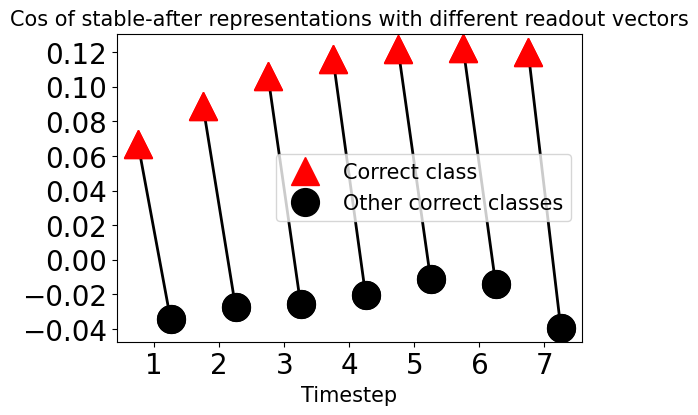

In [19]:
plt.figure(figsize=(6,4))
for t in range(1,timesteps_analyse):
    plt.plot(2*t,cos_classes_unstable[t,0],'^', color='red',markersize=20)
    plt.plot(2*t+1,cos_classes_unstable[t,1],'o', color='black',markersize=20)
    plt.plot(range(2*(t),2*t+2),cos_classes_unstable[t,:],'k-',linewidth=2)
    plt.plot(2*t,cos_classes_unstable[t,0],'^', color='red',markersize=20)
    plt.plot(2*t+1,cos_classes_unstable[t,1],'o', color='black',markersize=20)
plt.legend(['Correct class','Other correct classes'],fontsize=15)
plt.yticks(fontsize=20);
plt.xticks(np.arange(1,timesteps_analyse)*2+0.5,labels=range(1,timesteps_analyse),fontsize=20);
plt.xlabel('Timestep',fontsize=15)
plt.title('Cos of stable-after representations with different readout vectors',fontsize=15);

print('Cos of stable-after representations is higher with corresponding final class than the final classes\
 of other stable-after representations.')

to_avg_t = np.invert(np.isnan(np.mean(cos_classes_unstable[:timesteps_analyse,:],axis=1)))
np.mean(cos_classes_unstable[np.arange(timesteps_analyse)[to_avg_t],:],axis=0)

### Comparison of metrics across network types

In [20]:
# Run the above script for the various RNN configurations - get the summary statistics and insert them here to visualise.
meas_diffs = np.zeros([2,2,2,3]) # diffs, L vs T, add vs mult, norm/cos/cos_other

meas_diffs[:,0,0,0] = np.array([8.03511149, 7.44929842]) # L - add
meas_diffs[:,1,0,0] = np.array([22.99320437, 22.43494606]) # T - add
meas_diffs[:,0,1,0] = np.array([24.14761542, 23.58096064]) # L - mult
meas_diffs[:,1,1,0] = np.array([22.43415347, 21.82737927]) # T - mult

meas_diffs[:,0,0,1] = np.array([0.20195132, 0.1209265 ])
meas_diffs[:,1,0,1] = np.array([0.06167901, 0.01399343])
meas_diffs[:,0,1,1] = np.array([0.13583924, 0.07096022])
meas_diffs[:,1,1,1] = np.array([0.08779555, 0.03271532])

meas_diffs[:,0,0,2] = np.array([ 0.09998333, -0.02352951])
meas_diffs[:,1,0,2] = np.array([ 0.00296173, -0.0740004 ])
meas_diffs[:,0,1,2] = np.array([ 0.05162896, -0.03233384])
meas_diffs[:,1,1,2] = np.array([ 0.01683858, -0.06554172])

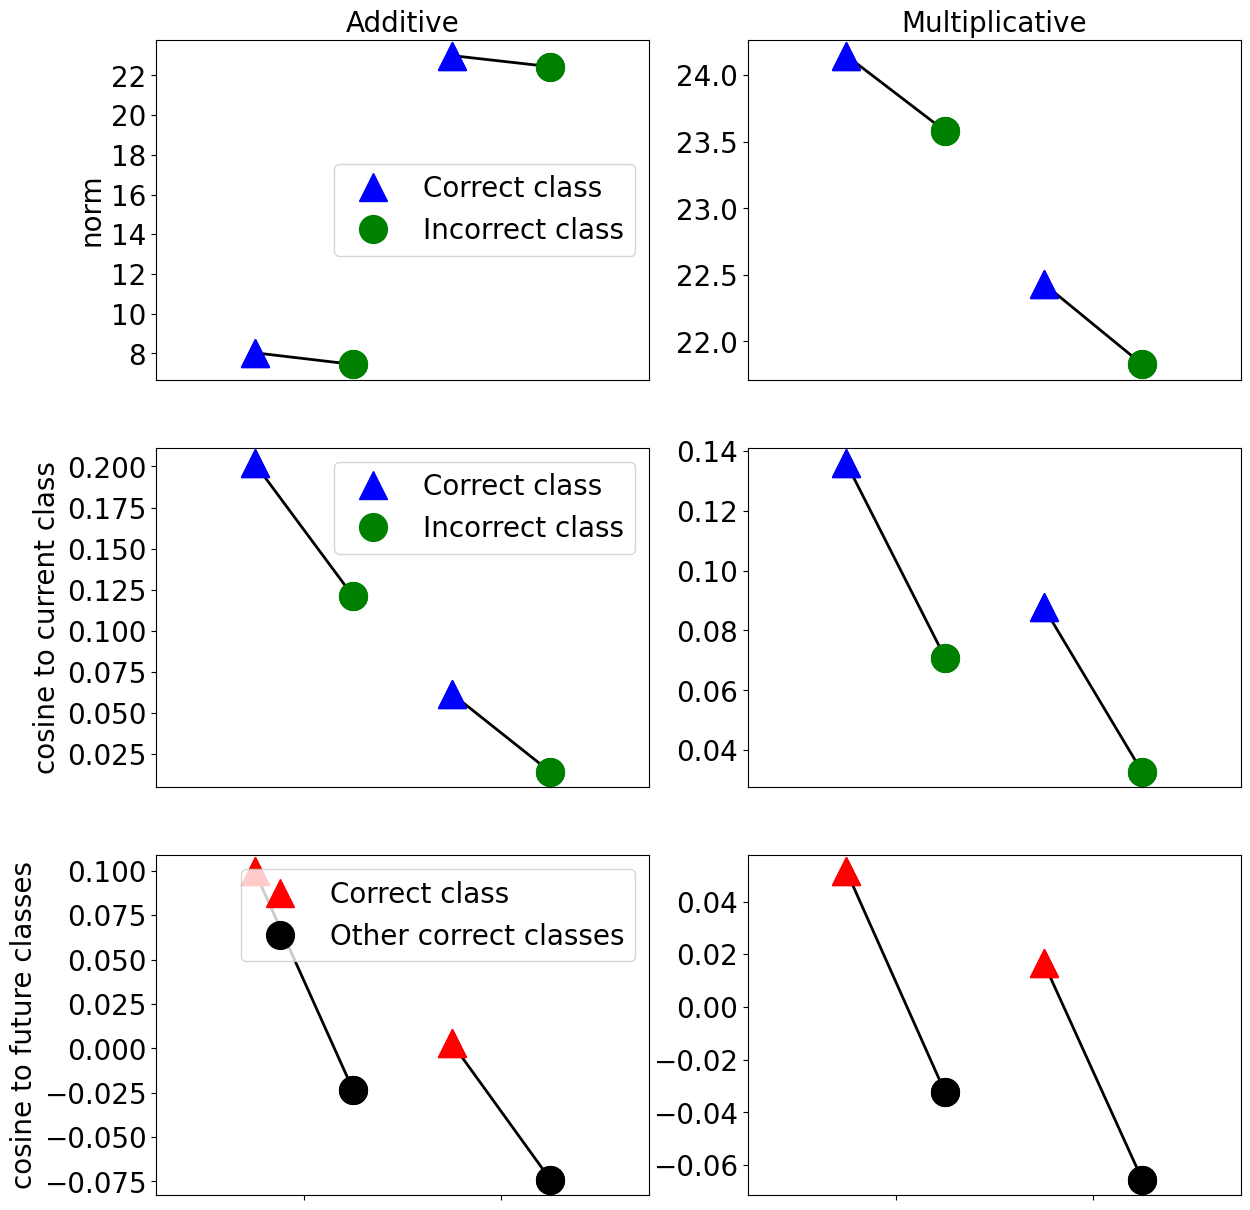

In [21]:
ylabels_h = [r'norm',r'cosine to current class',r'cosine to future classes']
titles_h = ['Additive','Multiplicative']

plt.figure(figsize=(14,15))
for intr in range(2):
    for meas in range(3):
        plt.subplot(3,2,intr+meas*2+1)
        for i in range(2):
            if meas < 2:
                plt.plot(0+i*2,meas_diffs[0,i,intr,meas],'b^',markersize=20)
                plt.plot(1+i*2,meas_diffs[1,i,intr,meas],'o', color='green',markersize=20)
                plt.plot(np.arange(2)+i*2,meas_diffs[:,i,intr,meas],'k-',linewidth=2)
                plt.plot(0+i*2,meas_diffs[0,i,intr,meas],'b^',markersize=20)
                plt.plot(1+i*2,meas_diffs[1,i,intr,meas],'o', color='green',markersize=20)
            else:
                plt.plot(0+i*2,meas_diffs[0,i,intr,meas],'r^',markersize=20)
                plt.plot(1+i*2,meas_diffs[1,i,intr,meas],'o', color='k',markersize=20)
                plt.plot(np.arange(2)+i*2,meas_diffs[:,i,intr,meas],'k-',linewidth=2)
                plt.plot(0+i*2,meas_diffs[0,i,intr,meas],'r^',markersize=20)
                plt.plot(1+i*2,meas_diffs[1,i,intr,meas],'o', color='k',markersize=20)
            if meas == 2:
                plt.xticks([0.5,2.5],labels=['',''],fontsize=20)
            else:
                plt.xticks([])
            plt.xlim([-1,4])
            plt.yticks(fontsize=20)
            if intr == 0:
                plt.ylabel(ylabels_h[meas],fontsize=20)
                if meas == 0:
                    plt.legend(['Correct class','Incorrect class'],fontsize=20)
                if meas == 1:
                    plt.legend(['Correct class','Incorrect class'],fontsize=20)
                if meas == 2:
                    plt.legend(['Correct class','Other correct classes'],fontsize=20)
            if meas == 0:
                plt.title(titles_h[intr],fontsize=20)